In [59]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
from collections import defaultdict
from sequencing_tools.viz_tools import okabeito_palette, \
                        simpsons_palette, \
                        RNA_base_from_picard, \
                        RNA_cov_from_picard, \
                        color_encoder
from collections import defaultdict
import re
import glob
import os
from plotting_utils import label_sample, rename_sample, \
                        label_ce, rna_type_ce, label_order, \
                        figure_path

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
def genome_rna():
    def change_type(x):
        if x == 'lncRNA':
            return 'Other ncRNA'
        else:
            return x
        
    return pd.read_table('/stor/work/Lambowitz/ref/hg19/new_genes/theoretical/theoretical_base_count.tsv') \
        .assign(grouped_type = lambda d: d.rna_type.map(lambda x: x.strip('b').strip("'"))) \
        .assign(grouped_type = lambda d: d.grouped_type.map(change_type))\
        .query('grouped_type != "other"')\
        .assign(base_fraction = lambda d: d.base_fraction / d.base_fraction.sum() * 100)\
        .pipe(pd.pivot_table, columns = 'grouped_type', values='base_fraction', aggfunc=np.sum) \
        .assign(treatment = 'Genome')\
        .set_index('treatment')

## plot count function

In [61]:
def plot_count(ax, feature_only=True, dedup=True):
    dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')


    filter_feature = 'No features' if feature_only else ''
    dedup_regex = ':dedup:' if dedup else ':all:'
    countplot_df = dedup_df \
        .filter(regex = 'type|Qcf|QCF|sim')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "vaultRNA",'Vault RNA', d.grouped_type))\
        .groupby('grouped_type')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains(dedup_regex)]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['grouped_type']) \
        .assign(variable = lambda d: d.variable.str.split(':', expand=True).iloc[:,0])\
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['grouped_type','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .query('grouped_type != "%s"' %filter_feature)\
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre|sim')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'grouped_type',
             values = 'value')\
        .reset_index() \
        .sort_values('treatment')\
        .set_index('treatment')\
        .pipe(lambda d: d.reindex(sorted(d.columns), axis=1))
    
    colors = rna_type_ce.transform(countplot_df.columns)
    countplot_df\
        .reindex(index=label_order)\
        .plot\
        .bar(stacked=True, 
             color = colors, 
              ax = ax,
             width = 0.8)
    xt = [xt.set_text(xt.get_text()) for xt in ax.get_xticklabels()]
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation = 70, ha = 'right',
                      rotation_mode="anchor")
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              bbox_to_anchor = (0.9,1), fontsize = 15,
             frameon=False)
    ax.set_xlabel('')
    ax.set_ylabel('Read pairs (%)')
    sns.despine()

# insert size

In [62]:
def plot_insert(ax):
    insert_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/fragment_sizes'
    data_files = glob.glob(insert_path + '/*.tsv')
    df = {os.path.basename(data_file):pd.read_table(data_file) for data_file in data_files}
    df = pd.concat([val.assign(label = key) for key, val in df.items()]) \
        .assign(label = lambda d: d.label.str.replace('.tsv','').str.capitalize())\
        .assign(label = lambda d: np.where(d.label == 'Polya','PolyA-selected', d.label))\
        .sort_values('isize') \
        .query('isize < 400') \
        .assign(size_fraction = lambda d: d.groupby('label')['size_count'].transform(lambda x: 100* x/ x.sum()))\
        .pipe(lambda d: d[d.label.str.contains('Alk|Un|[Ee]xo|All')]) \
        .assign(label = lambda d: d.label.map(label_sample)) 
    
    for lab, lab_df in df.groupby('label'):
        ax.plot(lab_df['isize'], 
                 lab_df['size_fraction'], 
                 linewidth=3,
                 label = lab,
                 color = label_ce.encoder[lab])
        
    ax.legend(title= ' ', 
             fontsize = 15, 
             frameon=False, 
             bbox_to_anchor = (0.6,0.8))
    ax.set_xlabel('Read span (nt)')
    ax.set_ylabel('Read pairs (%)')
    
    
    for i, label in enumerate(ax.get_xticklabels()):
        label.set_x(label.get_position()[0] + 1)

In [63]:
metric_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/merged_bam/filtered_bam'
metrics = glob.glob(metric_path + '/*.filtered.RNA_Metrics')

def read_metric(metric):
    return pd.read_table(metric, skiprows=6, nrows=1)\
        .pipe(pd.melt) \
        .pipe(lambda d: d[d.variable.str.contains('TRANSCRIPT_STRAND_')])\
        .pipe(lambda d: d[d.variable.str.contains('PCT')]) 

def plot_strand(ax):
    strand_df = {os.path.basename(metric).split('.')[0]: read_metric(metric) for metric in metrics}
    strand_df = pd.concat([d.assign(samplename = k) for k, d in strand_df.items()])\
        .pipe(lambda d: d[d.samplename.str.contains('[uU]nt|unf|[Aa]lka|[eE]xo|sim')])\
        .assign(samplename = lambda d: d.samplename.map(label_sample))\
        .assign(variable = lambda d: np.where(d.variable.str.contains('R1'), 'Sense','Antisense'))\
        .assign(value = lambda d: d['value'] * 100)\
        .pipe(pd.pivot_table, index='samplename', columns = 'variable', values = 'value')\
        .reindex(index=label_order)\
        .plot.bar(stacked=True, ax = ax, width = 0.8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right',rotation_mode="anchor")
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('Protein-coding bases (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              bbox_to_anchor = (.9,1), fontsize = 15,
             frameon=False)
    
    
def plot_coding_bases(ax):
    RNA_base_from_picard(metrics) \
        .assign(var_count = lambda d: d.var_count*100)\
        .pipe(lambda d: d[d.samplename.str.contains('[eE]xo|[uU]nt|unf|[Aa]lka|sim')])\
        .assign(samplename = lambda d: d.samplename.str.split('.',expand=True).iloc[:,0].map(label_sample))\
        .assign(variable = lambda d: d.variable.str.replace('Utr','UTR'))\
        .assign(variable = lambda d: d.variable.str.replace(' bases',''))\
        .pipe(pd.pivot_table, columns = 'variable', index='samplename', values = 'var_count')\
        .reindex(index=label_order)\
        .plot.bar(stacked=True, width = 0.8, color = simpsons_palette(), ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right',rotation_mode="anchor")
    ax.set_ylabel('Protein-coding bases (%)')
    ax.set_xlabel('')
    ax.legend(title = '', bbox_to_anchor = (1,1))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], bbox_to_anchor = (0.9,1), 
              fontsize = 15, frameon=False)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


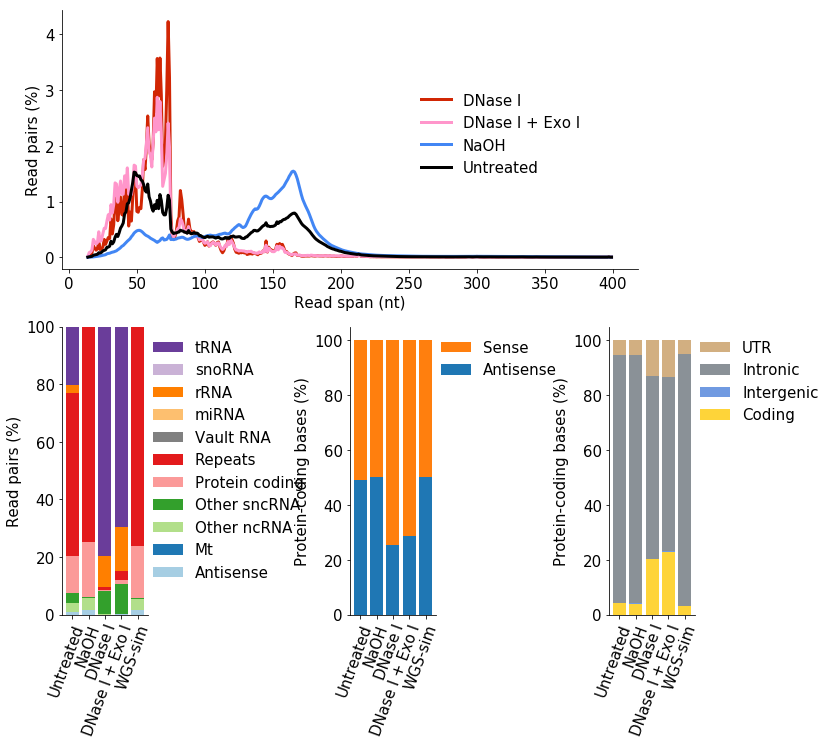

In [66]:
fig = plt.figure(figsize = (8,8))
ax_insert = fig.add_axes([0,0.6,1,0.45])
plot_insert(ax_insert)



# lower
ax_frag_dist = fig.add_axes([0,0,0.15,0.5])
ax_strand = fig.add_axes([0.5,0,0.15,0.5])
ax_coding = fig.add_axes([0.95,0,0.15,0.5])


#plot_count(ax_frag_dist, feature_only=False)
plot_count(ax_frag_dist, feature_only=True)
plot_strand(ax_strand)
plot_coding_bases(ax_coding)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


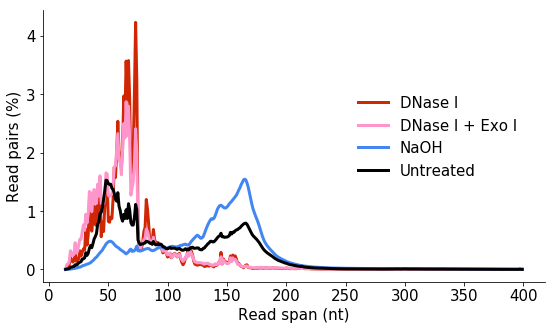

In [65]:
fig = plt.figure(figsize = (9,5))
ax_insert = fig.add_subplot(111)
plot_insert(ax_insert)
sns.despine()
fig.savefig(figure_path + '/insert_plots.pdf', bbox_inches = 'tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


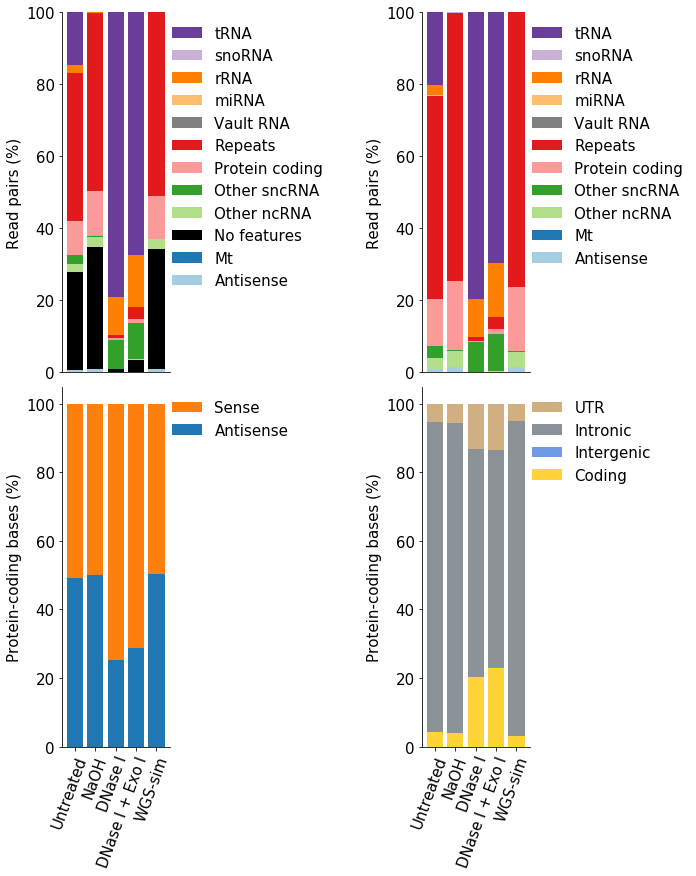

In [64]:
#fig = plt.figure(figsize = (10,8))
#ax_frag_dist = fig.add_axes([0,0,0.15,0.5])
#ax_frag_dist_feature_only = fig.add_axes([0.5,0,0.15,0.5])
#ax_strand = fig.add_axes([1,0,0.15,0.5])
#ax_coding = fig.add_axes([1.4,0,0.15,0.5])

fig = plt.figure(figsize = (10,10))
ax_frag_dist = fig.add_axes([0,0.52,0.15,0.5])
ax_frag_dist_feature_only = fig.add_axes([0.5,0.52,0.15,0.5])
ax_strand = fig.add_axes([0,0,0.15,0.5])
ax_coding = fig.add_axes([0.5,0, 0.15, 0.5])


plot_count(ax_frag_dist, feature_only=False)
ax_frag_dist.xaxis.set_visible(False)
plot_count(ax_frag_dist_feature_only, feature_only=True)
ax_frag_dist_feature_only.xaxis.set_visible(False)
plot_strand(ax_strand)
plot_coding_bases(ax_coding)
#fig.tight_layout()
fig.savefig(figure_path + '/fragment_plots.pdf', bbox_inches = 'tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.1,0.86,"Pearson's $\\rho$")

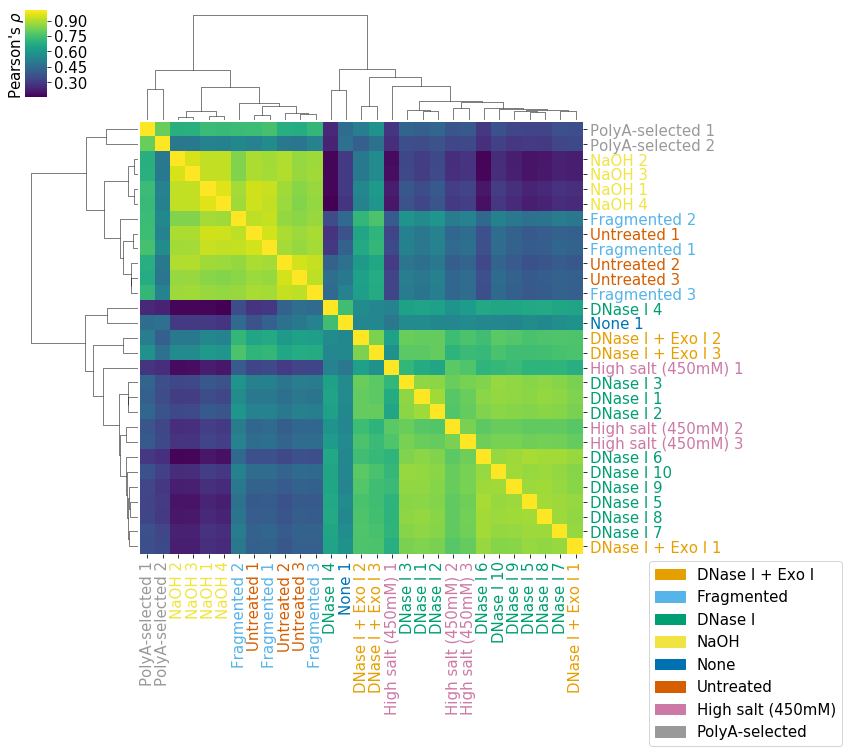

In [128]:
from collections import defaultdict
dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')
cor_df = np.log(dedup_df\
                    .filter(regex = 'Qcf|QCF')\
                    .filter(regex="dedup:sense") \
                    .pipe(lambda d: d+1))
cor_df.columns = rename_sample(cor_df.columns)
cor_df = cor_df.corr(method='pearson')
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.str.replace(' [0-9]+$',''), 
                 okabeito_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.6,0.), fontsize=15)
p.fig.text(0.1, 0.86, r"Pearson's $\rho$", rotation = 90, fontsize=15)

In [129]:
strand_df = {os.path.basename(metric).split('.')[0]: read_metric(metric) for metric in metrics}
pd.concat([d.assign(samplename = k) for k, d in strand_df.items()])\
        .pipe(lambda d: d[d.samplename.str.contains('unf|[Aa]lka')])\
        .assign(samplename = lambda d: np.where(d.samplename.str.contains('[aA]lka'),'Alkaline\nhydrolysis','DNase\ntreated'))\
        .assign(variable = lambda d: np.where(d.variable.str.contains('R1'), 'Sense strand','Antisense-strand'))\
        .assign(value = lambda d: d['value'] * 100)\
        .pipe(pd.pivot_table, index='samplename', columns = 'variable', values = 'value')

ValueError: No objects to concatenate

In [130]:
RNA_base_from_picard(metrics) \
    .pipe(lambda d: d[d.samplename.str.contains('unfr|alka')]) \
    .assign(var_count = lambda d: d.var_count*100)\
    .assign(samplename = lambda d: np.where(d.samplename.str.contains('[Aa]lk'), 'Alkaline hydrolysis', 'DNase-treated'))\
    .pipe(pd.pivot_table, columns = 'variable', index='samplename', values = 'var_count')

ValueError: No objects to concatenate

In [131]:
def plot_count_with_genome(ax):
    dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')


    countplot_df = dedup_df \
        .filter(regex = 'type|Qcf|QCF')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .groupby('grouped_type')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['grouped_type']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['grouped_type','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'grouped_type',
             values = 'value')\
        .reset_index() \
        .sort_values('treatment')\
        .set_index('treatment')\
        .pipe(lambda d: d.reindex(sorted(d.columns), axis=1))
    
    colors = rna_type_ce.transform(countplot_df.columns)
    countplot_df\
        .pipe(lambda d: pd.concat([d, genome_rna()], sort=True))\
        .reindex(index=np.append('Genome', label_order))\
        .plot\
        .bar(stacked=True, 
             color = colors, 
              ax = ax,
             width = 0.8)
    xt = [xt.set_text(xt.get_text()) for xt in ax.get_xticklabels()]
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right')
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              bbox_to_anchor = (1,1), fontsize = 15,
             frameon=False)
    ax.set_xlabel('')
    ax.set_ylabel('Read pairs (%)')
    sns.despine()

ValueError: Contain unseen data!!: vaultRNA

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


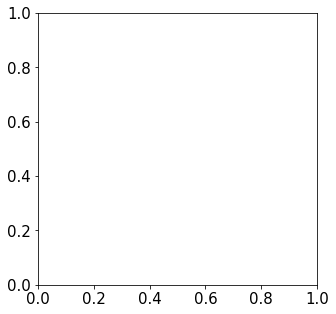

In [132]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plot_count_with_genome(ax)

In [ ]:
np.append('Genome', label_order)

In [ ]:
countplot_df = dedup_df \
        .filter(regex = 'type|Qcf|QCF')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .groupby('grouped_type')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['grouped_type']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['grouped_type','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'grouped_type',
             values = 'value')\
        .reset_index() \
        .sort_values('treatment')\
        .set_index('treatment')\
        .pipe(lambda d: d.reindex(sorted(d.columns), axis=1))
countplot_df

In [ ]:
dedup_df \
        .filter(regex = 'id|type|Qcf|QCF')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .query('grouped_type == "rRNA"')\
        .groupby('gene_id')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup|gene_id')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['gene_id']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['gene_id','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'gene_id',
             values = 'value')

In [ ]:
28.2 + 62.98

In [ ]:
6.075118 + 2.731050

In [191]:
dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')


countplot_df = dedup_df \
        .filter(regex = 'id|type|Q[cC][fF][0-9]+')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "caultRNA", 'Vault RNA', d.grouped_type))\
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('id|type|dedup')]]) \
        .pipe(lambda d: d[d.grouped_type.str.contains('sno|tRN|vault|sncRNA|mi|snR')]) \
        .assign(sum_count = lambda d: d.iloc[:,3:].sum(axis=1)) \
        .groupby(['grouped_type'], as_index=False)\
        .apply(lambda d: d.nlargest(10, 'sum_count'))\
        .reset_index()
#        .pipe(pd.melt, id_vars = ['grouped_type']) \
#        .assign(treatment = lambda d: d.variable.map(label_sample)) \
#        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])
countplot_df.head()

,level_0,level_1,gene_id,gene_type,grouped_type,QCF1_R1_001:dedup:sense,QCF2_R1_001:dedup:sense,Qcf10_R1_001:dedup:sense,Qcf11_R1_001:dedup:sense,Qcf4_R1_001:dedup:sense,Qcf5_R1_001:dedup:sense,Qcf6_SS_R1_001:dedup:sense,Qcf7_R1_001:dedup:sense,Qcf8_R1_001:dedup:sense,Qcf9_R1_001:dedup:sense,sum_count
0,0,60312,RNY4(+),Y_RNA,Other sncRNA,71194,79894,52364,108232,54503,45231,56250,71322,41460,29953,610403
1,0,60301,RNY3(+),Y_RNA,Other sncRNA,53663,54058,47301,98381,60066,46047,64869,66699,36020,31240,558344
2,0,60292,RNY1(-),Y_RNA,Other sncRNA,44706,46384,37269,87542,51593,42416,58842,53282,25769,22019,469822
3,0,89450,piRNA,piRNA,Other sncRNA,0,0,0,152079,0,0,0,0,0,0,152079
4,0,89454,piRNA,piRNA,Other sncRNA,0,0,0,152079,0,0,0,0,0,0,152079


In [194]:
long_phos = pd.read_table('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')\
    .filter(regex='id|name|grouped|L[12]|Frag|Phos|Qcf11|Qcf6') \
    .filter(regex = 'id|name|grouped|dedup:sense')\
    .rename(columns = lambda x: x.split(':')[0])\
    .rename(columns = {'Qcf_Frag3_R1_001':'Qcf_Phos1_R1_001',
                      'Qcf_Phos1_R1_001': 'Qcf_Frag3_R1_001'})\
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
long_phos.head()

,gene_id,gene_name,grouped_type,Qcf11_R1_001,Qcf6_SS_R1_001,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_Phos1_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,Qcf_Frag3_R1_001
0,18S_rRNA,18S_rRNA,rRNA,182471,180938,722810,466207,630280,2299,1652,1725150
1,28S_rRNA,28S_rRNA,rRNA,390312,462565,1197746,718897,1576496,14060,19095,2866628
2,5.8S_rRNA,5.8S_rRNA,rRNA,163354,185419,81930,48221,210513,385,192,117775
3,5S_rRNA,5S_rRNA,rRNA,131571,103777,58308,48299,128090,267,75,79978
4,Alu,SINE:AluJb,Repeats,76,152,14801,12090,18628,4598,850,131


Text(0,0.5,'Read pairs (%)')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


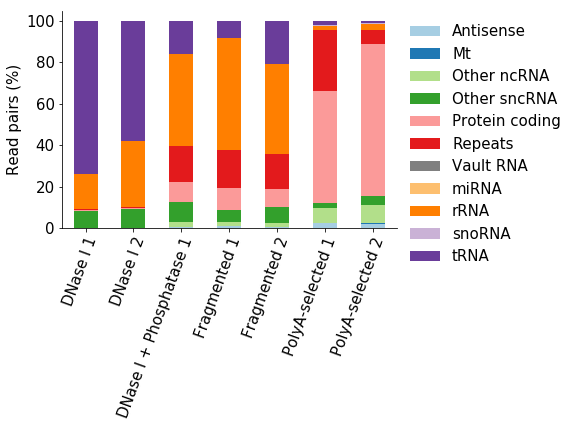

In [204]:
ax = plt.subplot(111)
pdf = long_phos\
    .drop('Qcf_Frag3_R1_001',axis=1)\
    .pipe(lambda d: d[~d.grouped_type.isin(['a'])]) \
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "vaultRNA", 'Vault RNA', d.grouped_type))\
    .drop(['gene_id','gene_name'], axis=1)\
    .groupby('grouped_type') \
    .sum() \
    .transform(lambda d: d/d.sum(axis=0) * 100) \
    .transpose()\
    .reset_index() \
    .assign(index = lambda d: rename_sample(d['index']))\
    .set_index('index')\
    .loc[['DNase I 1', 'DNase I 2', 'DNase I + Phosphatase 1', 
          'Fragmented 1', 'Fragmented 2', 
         'PolyA-selected 1', 'PolyA-selected 2'],:]
pdf.plot.bar(stacked=True, ax = ax, color = rna_type_ce.transform(pdf.columns))
ax.legend(bbox_to_anchor = (1,1), frameon=False, fontsize=15)
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, rotation_mode = 'anchor', ha = 'right')
ax.set_xlabel('')
ax.set_ylabel('Read pairs (%)')

Text(0.5,3.2,'')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


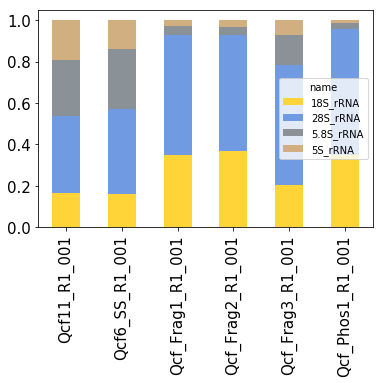

In [160]:
a = long_phos \
    .pipe(lambda d: d[d.columns[~d.columns.str.contains('L[12]')]])\
    .query('grouped_type == "rDNA"') \
    .set_index('name')\
    .drop(['id','grouped_type'], axis=1) \
    .transform(lambda d: d/d.sum(axis=0)) \
    .transpose()\
    .plot.bar(color=simpsons_palette(), stacked=True)
ax.set_ylabel('Enrichment (relative to 5S_rRNA)')
ax.set_xlabel('')

In [151]:
a.apply(lambda d: d/d.sum(axis=0))

,Qcf11_R1_001,Qcf6_SS_R1_001,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_Frag3_R1_001,Qcf_Phos1_R1_001
name,,,,,,
18S_rRNA,0.165363,0.162261,0.350144,0.369621,0.203459,0.347832
28S_rRNA,0.372827,0.407584,0.579959,0.558026,0.578638,0.608556
5.8S_rRNA,0.270902,0.289223,0.041836,0.039787,0.147014,0.029342
5S_rRNA,0.190908,0.140932,0.028061,0.032566,0.070889,0.014270


In [137]:
long_phos\
    .query('grouped_type=="Other ncRNA"')\
    .pipe(lambda d: d[d.iloc[:,3:].sum(axis=1)>0]) \
    .sort_values('Qcf_Frag3_R1_001', ascending=False) 

,id,grouped_type,name,Qcf11_R1_001,Qcf6_SS_R1_001,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_Frag3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,Qcf_Phos1_R1_001
59344,ENSG00000283029.1_4,Other ncRNA,RN7SL1,6301.0,3415.0,8182.0,10149,31490.0,22.0,29.0,52624.0
54010,ENSG00000270103.3_4,Other ncRNA,RNU11,1153.0,800.0,2095.0,3083,1889.0,3.0,0.0,912.0
29550,ENSG00000229140.9_4,Other ncRNA,CCDC26,4.0,3.0,590.0,562,1262.0,215.0,41.0,11.0
31524,ENSG00000231918.1_5,Other ncRNA,AC007682.1,9.0,3.0,529.0,502,1209.0,365.0,64.0,13.0
55155,ENSG00000271955.1_5,Other ncRNA,RP11-444A22.1,5.0,5.0,539.0,571,1104.0,154.0,22.0,8.0
55103,ENSG00000271860.6_4,Other ncRNA,RP11-436D23.1,1.0,8.0,506.0,405,1049.0,333.0,43.0,4.0
27101,ENSG00000225630.1_3,Other ncRNA,RP5-857K21.8,273.0,79.0,316.0,357,1040.0,1769.0,2543.0,1659.0
31099,ENSG00000231304.2_4,Other ncRNA,AC099057.8,3.0,7.0,472.0,515,970.0,247.0,27.0,4.0
29079,ENSG00000228430.9_5,Other ncRNA,RP11-15B24.5,3.0,6.0,405.0,482,967.0,149.0,24.0,5.0
30178,ENSG00000230021.9_4,Other ncRNA,RP11-206L10.17,72.0,90.0,465.0,489,958.0,6077.0,10118.0,211.0


In [ ]:
pd.read_table('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/fragment_sizes/all.tsv') \
    .sort_values('isize')\
    .query('isize<400')\
    .plot('isize','size_count')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
